# Предложение 1

Ввести дифференцированную оплату в зависимости от зоны посадки/высадки

In [1]:
import clickhouse_connect
import json
from dotenv import load_dotenv
import os
from IPython.display import display
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
# Read config from file
with open('dags/conf/config.json', 'r') as f:
    CONFIG = json.load(f)

# Load environment variables
load_dotenv('./dags/conf/.env', override=True)

# TODO - for Clickhouse in Docker set host name
CONFIG['clickhouse']['host'] = 'localhost'
db = CONFIG['clickhouse']['dbs']['golden_db']

# Get Clickhouse connection
ch_client = clickhouse_connect.get_client(
    host=CONFIG['clickhouse']['host'],
    port=CONFIG['clickhouse']['port'],
    username=os.getenv('CLICKHOUSE_USER'),
    password=os.getenv('CLICKHOUSE_PASS')
)


In [3]:
# Explore how much Manhattan prevails in numbers
# Get aggregated data
sql = f"""
    WITH man AS (
        SELECT ft.fare_amount,
            (dtz1.borough = 'Manhattan' OR dtz2.borough = 'Manhattan') AS is_manhattan
        FROM {db}.fact_trip ft
            JOIN {db}.dim_taxi_zone dtz1
                ON ft.PULocationID = dtz1.taxi_zone_id 
            JOIN {db}.dim_taxi_zone dtz2
                ON ft.DOLocationID = dtz2.taxi_zone_id
    )
    SELECT COUNT(*) AS total_trips,
        SUM(is_manhattan) AS manhattan_trips,
        SUM(fare_amount) AS total_revenue,
        SUM(fare_amount * is_manhattan) AS manhattan_revenue
    FROM man
    """

try:
    df = ch_client.query_df(sql)
    print(df.head(10))

except Exception as e:
    print(f"Error querying data: {e}")
    raise


   total_trips  manhattan_trips  total_revenue  manhattan_revenue
0     16816069          6352879   1.547895e+08       5.925930e+07


In [4]:
results = {
    'Total Trips': df['total_trips'].iloc[0],
    'Manhattan Trips': df['manhattan_trips'].iloc[0],
    'Manhattan Trip %': (df['manhattan_trips'].iloc[0] / df['total_trips'].iloc[0]) * 100,
    'Total Revenue ($)': df['total_revenue'].iloc[0],
    'Manhattan Revenue ($)': df['manhattan_revenue'].iloc[0],
    'Manhattan Revenue %': df['manhattan_revenue'].iloc[0] / df['total_revenue'].iloc[0] * 100
}
print(results)

print(f'\n\nManhattan dominance:')
print(f"  Trips: {round(results['Manhattan Trip %'], 1)}%")
print(f"  Revenue: {round(results['Manhattan Revenue %'], 1)}%")


{'Total Trips': 16816069, 'Manhattan Trips': 6352879, 'Manhattan Trip %': 37.77862115099552, 'Total Revenue ($)': 154789504.07993245, 'Manhattan Revenue ($)': 59259295.02001108, 'Manhattan Revenue %': 38.28379409330616}


Manhattan dominance:
  Trips: 37.8%
  Revenue: 38.3%


In [5]:
# Manhattan prevalence analysis
pd_results = pd.DataFrame([results])
pd_results['Manhattan Trip %'] = pd_results['Manhattan Trip %'].map("{:.2f}%".format)
pd_results['Manhattan Revenue %'] = pd_results['Manhattan Revenue %'].map("{:.2f}%".format)

styled = (pd_results
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)


Total Trips,Manhattan Trips,Manhattan Trip %,Total Revenue ($),Manhattan Revenue ($),Manhattan Revenue %
16816069,6352879,37.78%,154789504.079932,59259295.020011,38.28%


Text(0.5, 1.0, 'Trip Distribution: Manhattan vs Other Boroughs')

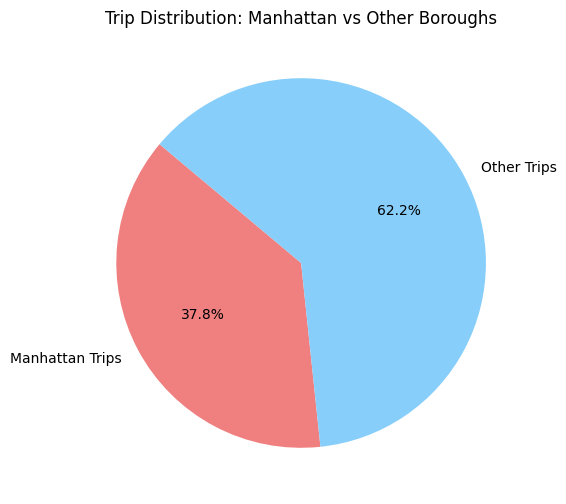

In [6]:
# Plot results on pie chart
labels = ['Manhattan Trips', 'Other Trips']
sizes = [results['Manhattan Trips'], results['Total Trips'] - results['Manhattan Trips']]
colors = ['lightcoral', 'lightskyblue']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Trip Distribution: Manhattan vs Other Boroughs')

In [7]:
# Get demand statistics for each zone by date and hour
# and assign each hour on each date a demand tier
sql = f"""
    WITH tmp AS
    (
        SELECT 
            ft.PULocationID AS taxi_zone_id,
            ddt.`date`,
            ddt.is_weekend,
            ddt.`hour`,
            COUNT(*) AS pickup_trips_count,
            AVG(ft.fare_amount) AS pickup_avg_fare,
            SUM(ft.fare_amount) AS pickup_total_fare
        FROM {db}.fact_trip ft
        JOIN {db}.dim_datetime ddt
            ON ft.pickup_datetime_id = ddt.datetime_id
        GROUP BY ft.PULocationID, ddt.`date`, ddt.is_weekend, ddt.`hour`
    )
    SELECT *,
        NTILE(3) OVER (ORDER BY pickup_trips_count) AS pu_tier
    FROM tmp
"""

try:
    # Get pickup zones statistics
    pickup_stats = ch_client.query_df(sql)

    print(pickup_stats.head(10))

except Exception as e:
    print(f"Error querying data: {e}")


   taxi_zone_id       date  is_weekend  hour  pickup_trips_count  \
0            26 2018-07-05       False    11                   3   
1            89 2018-08-12        True    15                   3   
2           119 2018-06-15       False     9                   3   
3           152 2018-11-07       False    20                   3   
4           130 2017-10-12       False     6                   3   
5            40 2018-10-18       False    23                   3   
6           241 2017-07-01        True     9                   3   
7           145 2017-08-15       False     2                   3   
8            70 2018-06-04       False     4                   3   
9           236 2017-11-22       False    19                   3   

   pickup_avg_fare  pickup_total_fare  pu_tier  
0         8.833333               26.5        2  
1        12.166667               36.5        2  
2        12.666667               38.0        2  
3         6.333333               19.0        2  
4     

In [8]:
# Add text caption of demand tier
tier_names = {
    1: 'Low',
    2: 'Medium',
    3: 'High'
}
pickup_stats['demand_tier'] = pickup_stats['pu_tier'].map(tier_names)
print(pickup_stats.head(10))

   taxi_zone_id       date  is_weekend  hour  pickup_trips_count  \
0            26 2018-07-05       False    11                   3   
1            89 2018-08-12        True    15                   3   
2           119 2018-06-15       False     9                   3   
3           152 2018-11-07       False    20                   3   
4           130 2017-10-12       False     6                   3   
5            40 2018-10-18       False    23                   3   
6           241 2017-07-01        True     9                   3   
7           145 2017-08-15       False     2                   3   
8            70 2018-06-04       False     4                   3   
9           236 2017-11-22       False    19                   3   

   pickup_avg_fare  pickup_total_fare  pu_tier demand_tier  
0         8.833333               26.5        2      Medium  
1        12.166667               36.5        2      Medium  
2        12.666667               38.0        2      Medium  
3      

In [9]:
print(f"\nDemand distribution:")
print(pickup_stats['demand_tier'].value_counts())



Demand distribution:
demand_tier
Low       519506
Medium    519505
High      519505
Name: count, dtype: int64


In [10]:
# Examples of high-demand zone-hours
print("\nTop 10 zone-hour combinations by demand:")
top_zones = pickup_stats.nlargest(10, 'pickup_trips_count')[
    ['taxi_zone_id', 'date', 'is_weekend', 'hour', 'pickup_trips_count', 'pickup_total_fare', 'demand_tier']
]
print(top_zones)



Top 10 zone-hour combinations by demand:
         taxi_zone_id       date  is_weekend  hour  pickup_trips_count  \
1558515           255 2017-11-05        True     1                 289   
1558514           255 2017-02-26        True     3                 268   
1558513           255 2017-02-26        True     1                 267   
1558512           255 2017-01-15        True     2                 265   
1558510           255 2017-04-30        True     1                 263   
1558511           255 2017-03-05        True     2                 263   
1558509           255 2017-07-01        True     0                 262   
1558507           255 2017-01-29        True     2                 260   
1558508           255 2017-01-22        True     1                 260   
1558506           255 2017-01-15        True     3                 257   

         pickup_total_fare demand_tier  
1558515             2745.0        High  
1558514             3019.0        High  
1558513             

In [11]:
# Zone segmentation by demand
styled_pu = (pickup_stats.head(10).sort_values(['taxi_zone_id'])
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled_pu)


taxi_zone_id,date,is_weekend,hour,pickup_trips_count,pickup_avg_fare,pickup_total_fare,pu_tier,demand_tier
26,2018-07-05 00:00:00,False,11,3,8.833333,26.500000,2,Medium
40,2018-10-18 00:00:00,False,23,3,7.166667,21.500000,2,Medium
70,2018-06-04 00:00:00,False,4,3,13.500000,40.500000,2,Medium
89,2018-08-12 00:00:00,True,15,3,12.166667,36.500000,2,Medium
119,2018-06-15 00:00:00,False,9,3,12.666667,38.000000,2,Medium
130,2017-10-12 00:00:00,False,6,3,12.666667,38.000000,2,Medium
145,2017-08-15 00:00:00,False,2,3,10.166667,30.500000,2,Medium
152,2018-11-07 00:00:00,False,20,3,6.333333,19.000000,2,Medium
236,2017-11-22 00:00:00,False,19,3,10.666667,32.000000,2,Medium
241,2017-07-01 00:00:00,True,9,3,9.833333,29.500000,2,Medium


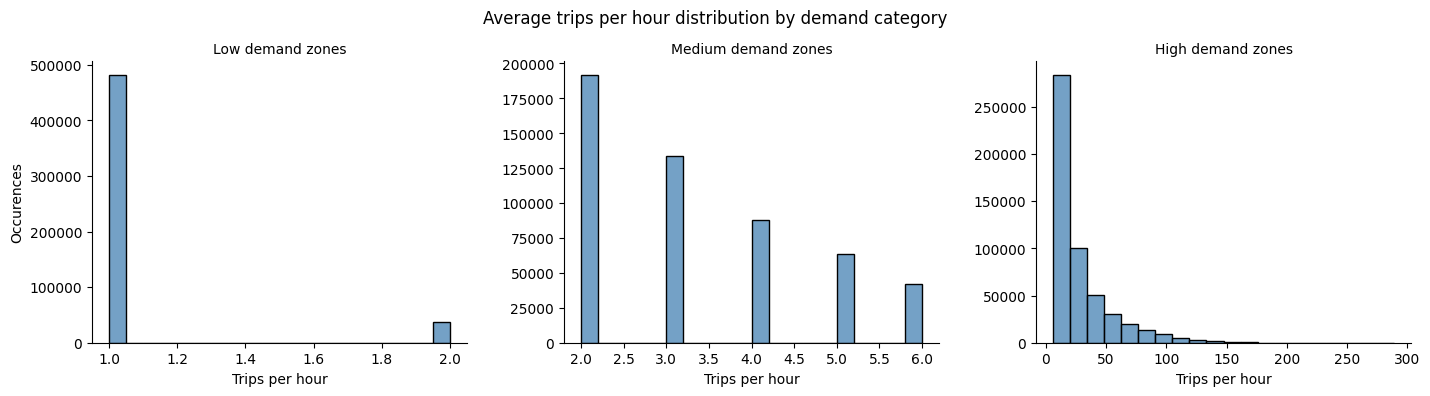

In [12]:
# Plot trips count distribution for each demand category
g = sns.FacetGrid(pickup_stats, col='demand_tier', col_order=['Low', 'Medium', 'High'], sharey=False, sharex=False, height=4, aspect=1.2)
g.map_dataframe(sns.histplot, x='pickup_trips_count', bins=20, color='steelblue')
g.set_axis_labels("Trips per hour", "Occurences")
g.set_titles(col_template="{col_name} demand zones")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Average trips per hour distribution by demand category")

plt.show()


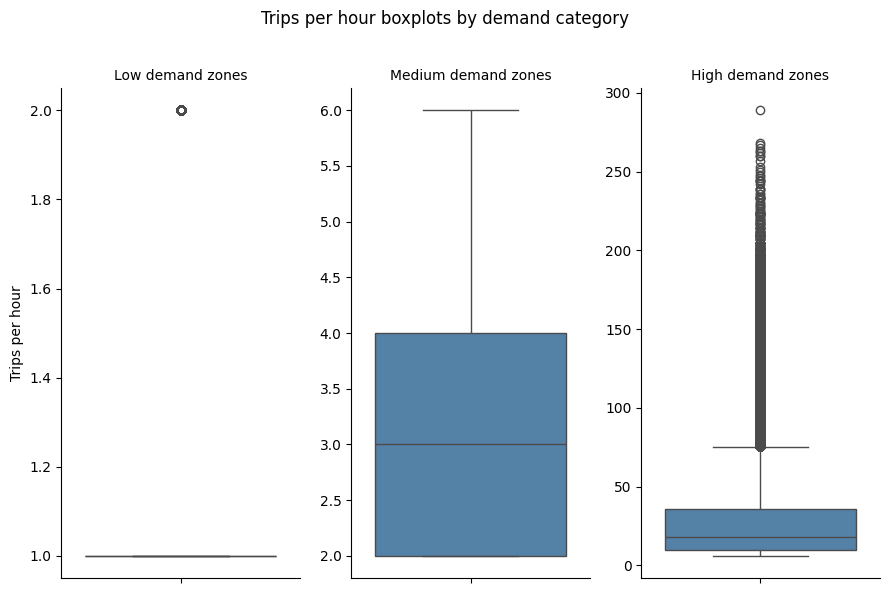

In [13]:
# Plot trips count boxplot for each demand category
g = sns.FacetGrid(pickup_stats, col='demand_tier', col_order=['Low', 'Medium', 'High'], sharey=False, sharex=False, height=6, aspect=0.5)
g.map_dataframe(sns.boxplot, y='pickup_trips_count', color='steelblue')
g.set_axis_labels("", "Trips per hour")
g.set_titles(col_template="{col_name} demand zones")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Trips per hour boxplots by demand category")

plt.show()

In [14]:
pickup_stats.describe()

,taxi_zone_id,date,hour,pickup_trips_count,pickup_avg_fare,pickup_total_fare,pu_tier
count,1.558516e+06,1558516,1.558516e+06,1.558516e+06,1.558516e+06,1.558516e+06,1.558516e+06
mean,1.294464e+02,2018-01-05 18:14:01.982501120,1.247521e+01,1.079557e+01,1.003995e+01,9.937124e+01,1.999999e+00
min,1.000000e+00,2017-01-01 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,6.300000e+01,2017-07-08 00:00:00,8.000000e+00,1.000000e+00,7.869565e+00,1.350000e+01,1.000000e+00
50%,1.270000e+02,2018-01-10 00:00:00,1.300000e+01,3.000000e+00,9.500000e+00,3.050000e+01,2.000000e+00
75%,1.930000e+02,2018-07-05 00:00:00,1.800000e+01,1.000000e+01,1.162500e+01,9.850000e+01,3.000000e+00
max,2.650000e+02,2019-01-01 00:00:00,2.300000e+01,2.890000e+02,2.700000e+01,3.019000e+03,3.000000e+00
std,7.601461e+01,NaN,6.384568e+00,1.925079e+01,3.547320e+00,1.713316e+02,8.164970e-01


In [15]:
# Add columns with price and trips count logs
zone_stats_logs = pickup_stats.copy()

# Prepare dataset for taking logs
zone_stats_logs = zone_stats_logs[(zone_stats_logs['pickup_avg_fare'] > 0) & (zone_stats_logs['pickup_trips_count'] > 0)]

# Take logs for log-log regression
zone_stats_logs['log_demand'] = np.log(zone_stats_logs['pickup_trips_count'])
zone_stats_logs['log_price'] = np.log(zone_stats_logs['pickup_avg_fare'])

# Sort dataset by zone and hour
zone_stats_logs = zone_stats_logs.sort_values(['taxi_zone_id', 'hour'])


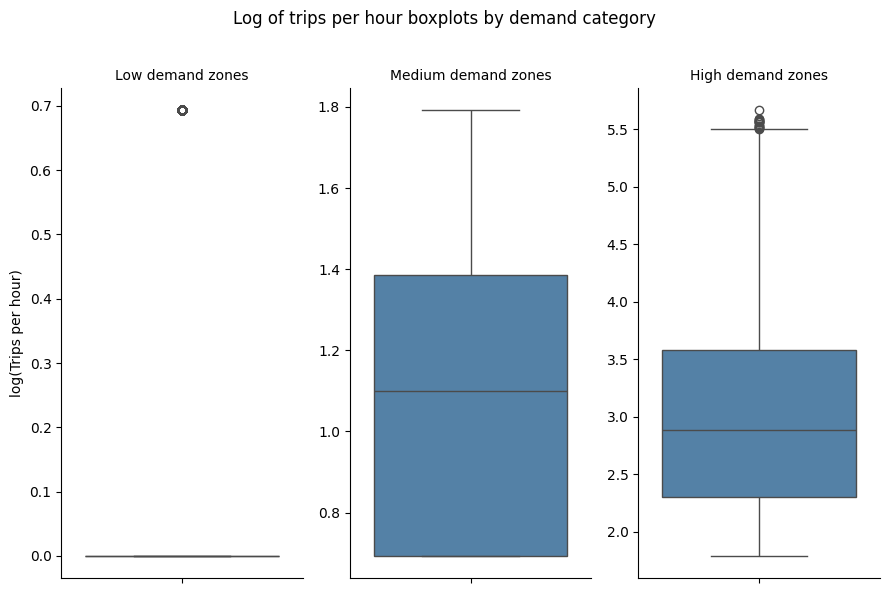

In [16]:
# Plot boxplots for trip count logs
g = sns.FacetGrid(zone_stats_logs, col='demand_tier', col_order=['Low', 'Medium', 'High'], sharey=False, sharex=False, height=6, aspect=0.5)
g.map_dataframe(sns.boxplot, y='log_demand', color='steelblue')
g.set_axis_labels("", "log(Trips per hour)")
g.set_titles(col_template="{col_name} demand zones")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Log of trips per hour boxplots by demand category")

plt.show()

In [17]:
demand_data = zone_stats_logs.copy()
# Add dummies and cast fileds to float to use in OLS model
demand_data = pd.get_dummies(demand_data, columns=['hour'], dtype=float, drop_first=True)
demand_data['is_weekend'] = demand_data['is_weekend'].astype(float)
print(demand_data.dtypes)

taxi_zone_id                  uint16
date                  datetime64[ns]
is_weekend                   float64
pickup_trips_count            uint64
pickup_avg_fare              float64
pickup_total_fare            float64
pu_tier                       uint64
demand_tier                   object
log_demand                   float64
log_price                    float64
hour_1                       float64
hour_2                       float64
hour_3                       float64
hour_4                       float64
hour_5                       float64
hour_6                       float64
hour_7                       float64
hour_8                       float64
hour_9                       float64
hour_10                      float64
hour_11                      float64
hour_12                      float64
hour_13                      float64
hour_14                      float64
hour_15                      float64
hour_16                      float64
hour_17                      float64
h

In [22]:
# Calculate demand elasticity
elasticity_by_tier = {}

for tier in ['High', 'Medium', 'Low']:
    tier_data = demand_data[demand_data['demand_tier'] == tier].copy()
    
    if len(tier_data) < 30:
        print(f"  {tier}: Not enough data (n={len(tier_data)})")
        continue
    
    X = tier_data[['log_price', 'is_weekend'] + [c for c in demand_data.columns if c.startswith('hour_')]].copy()
    y = tier_data['log_demand']

    model_tier = sm.OLS(y, X).fit()
    
    print('\n\n', '+' * 10, tier.upper(), '+' * 40)
    print(model_tier.summary())
    print('+' * 60)


    elasticity_by_tier[f'{tier}'] = model_tier.params['log_price']
    elasticity_by_tier[f'{tier}_R2'] = model_tier.rsquared




 ++++++++++ HIGH ++++++++++++++++++++++++++++++++++++++++
                                 OLS Regression Results                                
Dep. Variable:             log_demand   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                          2.889e+05
Date:                Mon, 15 Dec 2025   Prob (F-statistic):                        0.00
Time:                        19:55:55   Log-Likelihood:                     -6.2447e+05
No. Observations:              519505   AIC:                                  1.249e+06
Df Residuals:                  519480   BIC:                                  1.249e+06
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      

In [23]:
print(elasticity_by_tier)

{'High': 1.1219204161323586, 'High_R2': 0.9328967622879367, 'Medium': 0.2816397115925775, 'Medium_R2': 0.881718318249568, 'Low': 0.01089327195838932, 'Low_R2': 0.07195488528551885}


In [24]:
# Price elasticity table view
elasticity_tbl = pd.DataFrame(elasticity_by_tier, index=[0])

styled = (
    elasticity_tbl
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)

High,High_R2,Medium,Medium_R2,Low,Low_R2
1.121920,0.932897,0.281640,0.881718,0.010893,0.071955


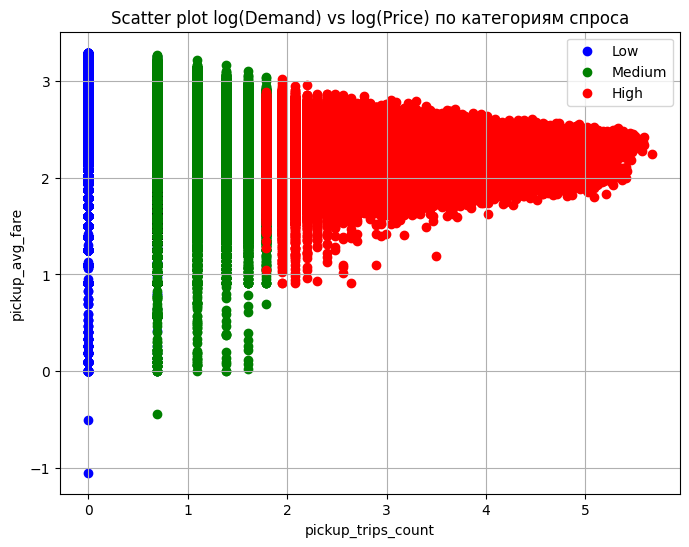

In [25]:
# Цвета для категорий
colors = {'Low': 'blue', 'Medium': 'green', 'High': 'red'}

# Построение scatter plot
plt.figure(figsize=(8,6))
for tier in zone_stats_logs['demand_tier'].unique():
    subset = zone_stats_logs[zone_stats_logs['demand_tier'] == tier]
    plt.scatter(subset['log_demand'], subset['log_price'], 
                label=tier, color=colors[tier])

plt.xlabel('pickup_trips_count')
plt.ylabel('pickup_avg_fare')
plt.title('Scatter plot log(Demand) vs log(Price) по категориям спроса')
plt.legend()
plt.grid(True)
plt.show()

D:\Temp\ipykernel_17468\2785118246.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


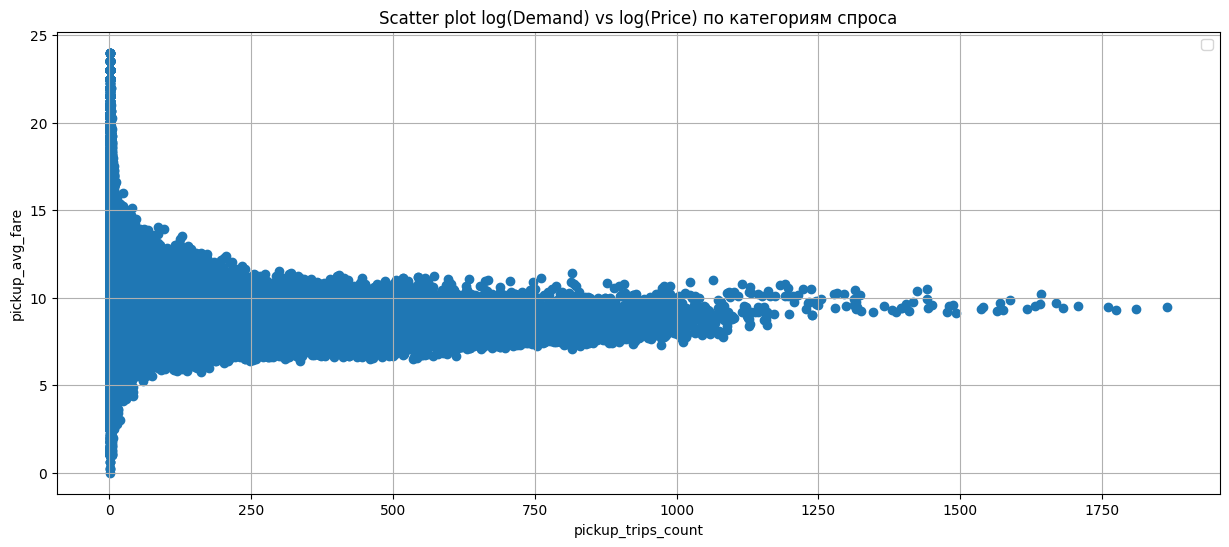

In [40]:
plt.figure(figsize=(15,6))
plt.scatter(zone_stats_logs['pickup_trips_count'], zone_stats_logs['pickup_avg_fare'])
plt.xlabel('pickup_trips_count')
plt.ylabel('pickup_avg_fare')
plt.title('Scatter plot log(Demand) vs log(Price) по категориям спроса')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Get aggregated statistics for trip types
# Trip type is defined by pickup zone demand tier and dropoff zone demand tier
sql = f"""
    -- Get dropoff zones trips per hour to calculate demand tier
    WITH do_agg AS (
        SELECT
            ft.DOLocationID AS taxi_zone_id,
            ddt.`date`,
            ddt.`hour`,
            COUNT(*) AS dropoff_trips_count
        FROM {db}.fact_trip ft
        JOIN {db}.dim_datetime ddt
            ON ft.dropoff_datetime_id = ddt.datetime_id
        GROUP BY ft.DOLocationID, ddt.`date`, ddt.`hour`
    ),
    -- Calculate dropoff zones demand tier
    do_tier AS (
        SELECT *,
            NTILE(3) OVER (ORDER BY dropoff_trips_count) AS do_tier
        FROM do_agg
    ),
    -- Calculate hour statistics for pickup zones
    pu_agg AS (
        SELECT
            ft.PULocationID AS taxi_zone_id,
            ddt.`date`,
            ddt.`hour`,
            COUNT(*) AS pickup_trips_count,
            AVG(ft.fare_amount) AS pickup_avg_fare,
            SUM(ft.fare_amount) AS pickup_total_fare
        FROM {db}.fact_trip ft
        JOIN {db}.dim_datetime ddt
            ON ft.pickup_datetime_id = ddt.datetime_id
        GROUP BY ft.PULocationID, ddt.`date`, ddt.`hour`
    ),
    -- Calculate pickup zones demand tier
    pu_tier AS (
        SELECT *,
            NTILE(3) OVER (ORDER BY pickup_trips_count) AS pu_tier
        FROM pu_agg
    ),
    pu_do AS (
        SELECT
            pu.*,
            do.do_tier
        FROM pu_tier pu
        JOIN do_tier do
            ON pu.taxi_zone_id = do.taxi_zone_id
            AND pu.date = do.date
            AND pu.hour = do.hour
    )
    -- Get final hour aggregates for trip types
    SELECT
        pu_tier,
        do_tier,
        AVG(pickup_trips_count) AS avg_pickup_trips_count,
        AVG(pickup_avg_fare) AS avg_pickup_fare,
        AVG(pickup_total_fare) AS avg_pickup_total_fare
    FROM pu_do
    GROUP BY pu_tier, do_tier
    ORDER BY pu_tier DESC, do_tier DeSC
"""

try:
    agg_df = ch_client.query_df(sql)

    print(agg_df.head(10))

except Exception as e:
    print(f"Error getting triptypes aggregates: {e}")


   pu_tier  do_tier  avg_pickup_trips_count  avg_pickup_fare  \
0        3        3               30.607401         9.113875   
1        3        2               11.819288        10.028760   
2        3        1               10.845466        10.501487   
3        2        3                3.791451         9.286190   
4        2        2                3.236366        10.187456   
5        2        1                2.864192        10.854587   
6        1        3                1.116600         9.502359   
7        1        2                1.093291        10.234214   
8        1        1                1.060368        10.669327   

   avg_pickup_total_fare  
0             274.918155  
1             119.431880  
2             114.649219  
3              35.113504  
4              32.874677  
5              30.967012  
6              10.598740  
7              11.189319  
8              11.327080  


In [27]:
# Add column with elasticity for each row
# Apply elasticity only to pickup tiers
agg_df['elasticity'] = agg_df['pu_tier'].map(tier_names).map(elasticity_by_tier).astype(float)

# Create trip type column based on pickup-dropoff tier combination
agg_df['trip_type'] = agg_df['pu_tier'].map(tier_names).astype(str) + '-' + agg_df['do_tier'].map(tier_names).astype(str)

print(agg_df.head(10))

   pu_tier  do_tier  avg_pickup_trips_count  avg_pickup_fare  \
0        3        3               30.607401         9.113875   
1        3        2               11.819288        10.028760   
2        3        1               10.845466        10.501487   
3        2        3                3.791451         9.286190   
4        2        2                3.236366        10.187456   
5        2        1                2.864192        10.854587   
6        1        3                1.116600         9.502359   
7        1        2                1.093291        10.234214   
8        1        1                1.060368        10.669327   

   avg_pickup_total_fare  elasticity      trip_type  
0             274.918155    1.121920      High-High  
1             119.431880    1.121920    High-Medium  
2             114.649219    1.121920       High-Low  
3              35.113504    0.281640    Medium-High  
4              32.874677    0.281640  Medium-Medium  
5              30.967012    0.28164

In [28]:
agg_disp = agg_df[['trip_type', 'elasticity', 'avg_pickup_trips_count', 'avg_pickup_fare', 'avg_pickup_total_fare']]
agg_disp.columns = ['Trip Type', 'Elasticity for PU zone', 'Avg Trips per Hour', 'Avg Trip Cost', 'Avg Revenue per Hour']
styled = (agg_disp
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)

Trip Type,Elasticity for PU zone,Avg Trips per Hour,Avg Trip Cost,Avg Revenue per Hour
High-High,1.121920,30.607401,9.113875,274.918155
High-Medium,1.121920,11.819288,10.028760,119.431880
High-Low,1.121920,10.845466,10.501487,114.649219
Medium-High,0.281640,3.791451,9.286190,35.113504
Medium-Medium,0.281640,3.236366,10.187456,32.874677
Medium-Low,0.281640,2.864192,10.854587,30.967012
Low-High,0.010893,1.116600,9.502359,10.598740
Low-Medium,0.010893,1.093291,10.234214,11.189319
Low-Low,0.010893,1.060368,10.669327,11.327080




 ++++++++++ BASELINE ++++++++++++++++++++++++++++++++++++++++
   pu_tier  do_tier  avg_pickup_trips_count  avg_pickup_fare  \
0        3        3               30.607401         9.113875   
1        3        2               11.819288        10.028760   
2        3        1               10.845466        10.501487   
3        2        3                3.791451         9.286190   
4        2        2                3.236366        10.187456   

   avg_pickup_total_fare  elasticity      trip_type scenario_name  \
0             274.918155     1.12192      High-High      baseline   
1             119.431880     1.12192    High-Medium      baseline   
2             114.649219     1.12192       High-Low      baseline   
3              35.113504     0.28164    Medium-High      baseline   
4              32.874677     0.28164  Medium-Medium      baseline   

   price_multiplier  price_new  trips_new  revenue_new  revenue_change  \
0                 1   9.113875  30.607401   278.952033        

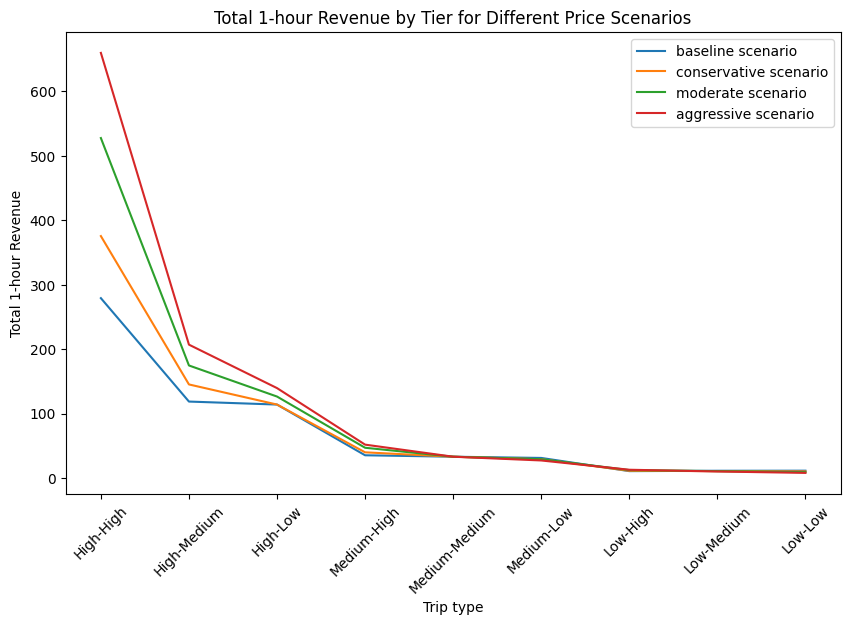

In [30]:
# Define pricing scenarios based on tier pairs
scenarios = {
    'baseline': {
        'High-High': 1, 'High-Medium': 1, 'High-Low': 1,
        'Medium-High': 1, 'Medium-Medium': 1, 'Medium-Low': 1,
        'Low-High': 1, 'Low-Medium': 1, 'Low-Low': 1
    },
    'conservative': {
        'High-High': 1.15, 'High-Medium': 1.10, 'High-Low': 1.00,
        'Medium-High': 1.10, 'Medium-Medium': 1.00, 'Medium-Low': 0.95,
        'Low-High': 1.05, 'Low-Medium': 0.95, 'Low-Low': 0.90
    },
    'moderate': {
        'High-High': 1.35, 'High-Medium': 1.20, 'High-Low': 1.05,
        'Medium-High': 1.25, 'Medium-Medium': 1.00, 'Medium-Low': 0.95,
        'Low-High': 1.15, 'Low-Medium': 0.95, 'Low-Low': 0.80
    },
    'aggressive': {
        'High-High': 1.50, 'High-Medium': 1.30, 'High-Low': 1.10,
        'Medium-High': 1.35, 'Medium-Medium': 1.00, 'Medium-Low': 0.90,
        'Low-High': 1.20, 'Low-Medium': 0.90, 'Low-Low': 0.70
    }
}

results_df = pd.DataFrame()

plt.figure(figsize=(10,6))

for scenario_name, price_multipliers in scenarios.items():
    df_scenario = agg_df.copy()
    
    # Add scenario name column
    df_scenario['scenario_name'] = scenario_name

    # Add price multipliers based on trip type
    df_scenario['price_multiplier'] = df_scenario['trip_type'].map(price_multipliers)

    # Calculate new values
    df_scenario['price_new'] = df_scenario['avg_pickup_fare'] * df_scenario['price_multiplier']
    df_scenario['trips_new'] = df_scenario['avg_pickup_trips_count'] * (df_scenario['price_multiplier']) ** df_scenario['elasticity']
    df_scenario['revenue_new'] = df_scenario['trips_new'] * df_scenario['price_new'] 
    df_scenario['revenue_change'] = df_scenario['revenue_new'] - df_scenario['avg_pickup_total_fare']
    df_scenario['revenue_change_pct'] = ((df_scenario['revenue_new'] - df_scenario['avg_pickup_total_fare']) / df_scenario['avg_pickup_total_fare']) * 100
    df_scenario['trips_change_pct'] = ((df_scenario['trips_new'] - df_scenario['avg_pickup_trips_count']) / df_scenario['avg_pickup_trips_count']) * 100
    
    print('\n\n', '+' * 10, scenario_name.upper(), '+' * 40)
    print(df_scenario.head(5))
    print('+'*60)
   
    results_df = pd.concat([results_df, df_scenario])

    plt.plot(df_scenario['trip_type'], df_scenario['revenue_new'], label=f'{scenario_name} scenario')

plt.xlabel('Trip type')
plt.xticks(rotation=45)
plt.ylabel('Total 1-hour Revenue')
plt.title('Total 1-hour Revenue by Tier for Different Price Scenarios')
plt.legend()
plt.show()


In [31]:
print(results_df.head(10))

   pu_tier  do_tier  avg_pickup_trips_count  avg_pickup_fare  \
0        3        3               30.607401         9.113875   
1        3        2               11.819288        10.028760   
2        3        1               10.845466        10.501487   
3        2        3                3.791451         9.286190   
4        2        2                3.236366        10.187456   
5        2        1                2.864192        10.854587   
6        1        3                1.116600         9.502359   
7        1        2                1.093291        10.234214   
8        1        1                1.060368        10.669327   
0        3        3               30.607401         9.113875   

   avg_pickup_total_fare  elasticity      trip_type scenario_name  \
0             274.918155    1.121920      High-High      baseline   
1             119.431880    1.121920    High-Medium      baseline   
2             114.649219    1.121920       High-Low      baseline   
3              35.1

In [32]:
# Show scenarios parameters
scenarios_df = pd.DataFrame.from_dict(scenarios, orient='index')
styled = (
    scenarios_df.T
    .style
    .format("{:.2f}")
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    # .hide(axis="index")
)

display(styled)


,baseline,conservative,moderate,aggressive
High-High,1.00,1.15,1.35,1.50
High-Medium,1.00,1.10,1.20,1.30
High-Low,1.00,1.00,1.05,1.10
Medium-High,1.00,1.10,1.25,1.35
Medium-Medium,1.00,1.00,1.00,1.00
Medium-Low,1.00,0.95,0.95,0.90
Low-High,1.00,1.05,1.15,1.20
Low-Medium,1.00,0.95,0.95,0.90
Low-Low,1.00,0.90,0.80,0.70


In [33]:
# Show scenarios results
results_disp = results_df[['scenario_name', 'trip_type', 'avg_pickup_trips_count', 'avg_pickup_fare',
            'avg_pickup_total_fare', 'price_new', 'trips_new',
            'revenue_new', 'revenue_change', 'revenue_change_pct',
            'trips_change_pct']]
results_disp.loc[results_disp.duplicated(subset=['scenario_name']), 'scenario_name'] = ''

styled = (results_disp.set_index('scenario_name')
    .style
    # .format("{:.2f}")
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    # .hide(axis="index")
)
    

display(styled)

,trip_type,avg_pickup_trips_count,avg_pickup_fare,avg_pickup_total_fare,price_new,trips_new,revenue_new,revenue_change,revenue_change_pct,trips_change_pct
scenario_name,,,,,,,,,,
baseline,High-High,30.607401,9.113875,274.918155,9.113875,30.607401,278.952033,4.033878,1.467301,0.000000
,High-Medium,11.819288,10.028760,119.431880,10.028760,11.819288,118.532796,-0.899084,-0.752800,0.000000
,High-Low,10.845466,10.501487,114.649219,10.501487,10.845466,113.893520,-0.755699,-0.659140,0.000000
,Medium-High,3.791451,9.286190,35.113504,9.286190,3.791451,35.208133,0.094629,0.269496,0.000000
,Medium-Medium,3.236366,10.187456,32.874677,10.187456,3.236366,32.970340,0.095664,0.290995,0.000000
,Medium-Low,2.864192,10.854587,30.967012,10.854587,2.864192,31.089620,0.122608,0.395931,0.000000
,Low-High,1.116600,9.502359,10.598740,9.502359,1.116600,10.610332,0.011592,0.109370,0.000000
,Low-Medium,1.093291,10.234214,11.189319,10.234214,1.093291,11.188970,-0.000349,-0.003120,0.000000
,Low-Low,1.060368,10.669327,11.327080,10.669327,1.060368,11.313416,-0.013664,-0.120630,0.000000


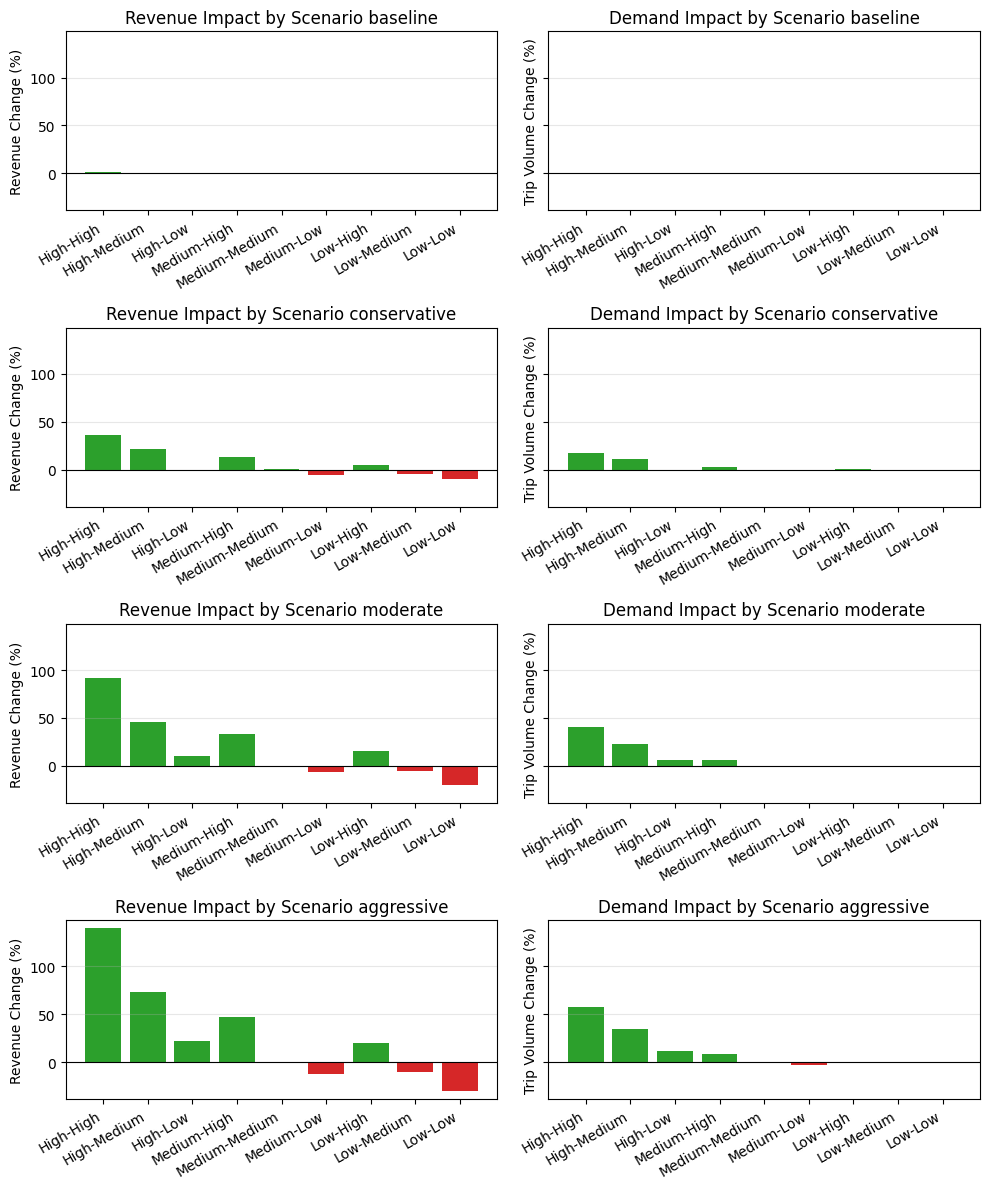

In [34]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12), sharex=False, sharey=True)
axes = axes.ravel()
    
scenarios = results_df['scenario_name'].drop_duplicates()

for idx, scenario in enumerate(scenarios):
    ax = axes[2*idx]
    cur_result = results_df[results_df['scenario_name'] == scenario]

    # Plot total revenue impact
    revenue_change = cur_result['revenue_change_pct']
    trip_types = cur_result['trip_type']
    colors_scenario = ['#7f7f7f' if x == 'baseline' else '#2ca02c' if x > 0 else '#d62728' 
                        for x in revenue_change]
    
    ax.bar(cur_result['trip_type'], revenue_change, color=colors_scenario)
    ax.set_xticks(range(len(trip_types)))
    ax.set_xticklabels(trip_types, rotation=30, ha='right')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_ylabel('Revenue Change (%)')
    ax.set_title(f'Revenue Impact by Scenario {scenario}')
    ax.grid(axis='y', alpha=0.3)

    ax = axes[2*idx+1]

    # Plot trips count impact
    trips_change = cur_result['trips_change_pct']
    colors_trips = ['#7f7f7f' if x == 'baseline' else '#2ca02c' if x > 0 else '#d62728' 
                    for x in trips_change]
    ax.bar(cur_result['trip_type'], trips_change, color=colors_trips)
    ax.set_xticks(range(len(trip_types)))
    ax.set_xticklabels(trip_types, rotation=30, ha='right')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_ylabel('Trip Volume Change (%)')
    ax.set_title(f'Demand Impact by Scenario {scenario}')
    ax.grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()
